# Create Equation of State and Fit Well with Varying Pressure

To use `bluebonnet.flow` in a project:

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sp
from scipy.interpolate import interp1d,UnivariateSpline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy import interpolate
from lmfit import minimize, Parameters,report_errors,conf_interval,Minimizer,printfuncs
from matplotlib.backends.backend_pdf import PdfPages
from FitFunctions import obfun

from bluebonnet.flow import (
    IdealReservoir, FlowProperties,  FlowPropertiesTwoPhase, 
    SinglePhaseReservoir,RelPermParams, relative_permeabilities
)
from bluebonnet.fluids.fluid import Fluid, pseudopressure,BuildPVT
from bluebonnet.forecast.forecast_pressure import _obj_function as obfun,fit_production_pressure as FitProductionWithPressure,plot_production_comparison
from bluebonnet.fluids import HallYarbEOS
from bluebonnet import plotting
pd.set_option('display.max_rows', 100)
import pickle as pkl
Results={}

# Test case with varying pressure

mf= 0.09720937870967307
CPU times: user 2.33 s, sys: 16.4 ms, total: 2.35 s
Wall time: 2.35 s
0.3642368902150243
0.09720937870967307 0.0008833922400551281 Deviation is    -1%


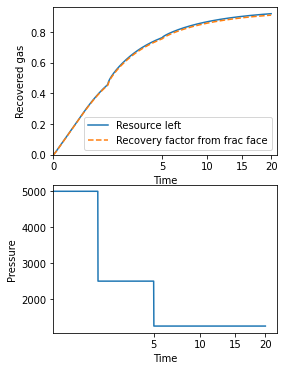

In [2]:
Pi=12000
Pf=5000

t_end = 10
time = np.linspace(0, np.sqrt(t_end), 10_000) ** 2
n_times=1000


t_end = 20
time = np.linspace(0, np.sqrt(t_end), n_times) ** 2
PressureTime=np.ones(n_times)
for i in range(n_times):
    if i<n_times/4: 
        PressureTime[i]=Pf 
    elif i<n_times/2:
        PressureTime[i]=Pf/2 
    else: 
        PressureTime[i]=Pf/4


pvt_gas = pd.read_csv("../tests/data/pvt_gas.csv").rename(
    columns={
        "P": "pressure",
        "Z-Factor": "z-factor",
        "Cg": "compressibility",
        "Viscosity": "viscosity",
    }
)


flow_propertiesM = FlowProperties(pvt_gas, Pi)

print('mf=',flow_propertiesM.m_scaled_func(Pf))

res_realgasM = SinglePhaseReservoir(100, Pf, Pi, flow_propertiesM)

%time res_realgasM.simulate(time,PressureTime)

rf2M = res_realgasM.recovery_factor()


density_interp = interpolate.interp1d(flow_propertiesM.pvt_props["m-scaled"], flow_propertiesM.pvt_props["Density"])

def resource_left(pseudopressure, pvt):
    density = interpolate.interp1d(pvt.pvt_props["m-scaled"], pvt.pvt_props["Density"])
    print(max(pvt.pvt_props["m-scaled"]))
    p=np.minimum(pseudopressure,max(pvt.pvt_props["m-scaled"]))
    return (density(p)).sum(axis=1)/len(pseudopressure[0])
mf=flow_propertiesM.m_scaled_func(Pf)
mi=flow_propertiesM.m_scaled_func(Pi)


remaining_gasM = (resource_left(res_realgasM.pseudopressure, flow_propertiesM) )/(density_interp(mi))
print(mf,res_realgasM.pseudopressure[-1][0],'Deviation is {:5.2g}%'.format((rf2M[-1]-1+remaining_gasM[-1])/rf2M[-1]*100))
fig, (ax1,ax2) = plt.subplots(2,1)
fig.set_size_inches(4, 6)
ax1.plot(time, 1 - remaining_gasM, label="Resource left")
ax1.plot(time, rf2M,"--", label="Recovery factor from frac face")
ax1.legend()
ax1.set(xlabel="Time", ylabel="Recovered gas", ylim=(0,None), xscale='squareroot', xlim=(0,None))

ax2.plot(time, PressureTime , label="Pressure")
ax2.set(xlabel="Time",  xscale='squareroot',ylabel="Pressure")

pp=PdfPages('PressureCheck.pdf')
pp.savefig(fig)
pp.close()

# If there are previous results saved, load this

In [2]:
Results=pkl.load(file=open("Results.pkl","rb"))

# Create Equation of State

## Read in data about a particular well

In [3]:
Location_SPE_Well_Data="../../PressureData/"
WellNumber=12

Filename2=Location_SPE_Well_Data+"SPE Well RTA Production Data/WellData_"+str(WellNumber)+".csv"
E=pd.read_csv(open(Filename2,"r"))
E=E.set_index('Field')
E=E.drop(columns='Unnamed: 0')
E.loc['Initial Pressure Estimate (psi)'][E.columns[0]]
Play=E.loc['Formation/Reservoir'][E.columns[0]]
E

,LORIKEET
Field,
Lease,LORIKEET
Well Number,62
State,LA
Formation/Reservoir,HAYNESVILLE SHALE
Initial Pressure Estimate (psi),9939
Reservoir Temperature (deg F),285.21375
Net Pay (ft),268.39703
Wellbore Diameter (ft),0.7
Porosity,0.0880000591278076


## Create equation of state from well data

In [10]:
FieldValues=E.iloc[:,0]
GasDryness='wet gas'
pvt_gas=BuildPVT(FieldValues,GasDryness)
pvt_gas.to_csv('../tests/data/pvt_gas_'+Play+'_'+str(WellNumber)+'.csv')
pvt_gas

,T,pressure,Density,z-factor,compressibility,viscosity,pseudopressure
0,285.21375,0.001,0.000002,1.000000,1000.000043,0.014637,0.000000e+00
1,285.21375,10.000,0.021024,0.999592,0.100043,0.014638,6.834483e+03
2,285.21375,20.000,0.042065,0.999181,0.050043,0.014638,2.734322e+04
3,285.21375,30.000,0.063123,0.998775,0.033376,0.014639,6.153650e+04
4,285.21375,40.000,0.084198,0.998370,0.025043,0.014639,1.094242e+05
...,...,...,...,...,...,...,...
1395,285.21375,13950.000,17.710554,1.655297,0.000029,0.029885,6.092854e+09
1396,285.21375,13960.000,17.715675,1.656005,0.000029,0.029895,6.098494e+09
1397,285.21375,13970.000,17.720791,1.656713,0.000029,0.029905,6.104133e+09
1398,285.21375,13980.000,17.725903,1.657421,0.000029,0.029915,6.109772e+09


## Or read equation of state from file

In [11]:
pvt_gas=pd.read_csv('../tests/data/pvt_gas_'+Play+'_'+str(WellNumber)+'.csv')
pvt_gas

{'viscosity', 'pseudopressure', 'compressibility', 'pressure', 'z-factor'}


,Unnamed: 0,T,pressure,Density,z-factor,compressibility,viscosity,pseudopressure
0,0,285.21375,0.001,0.000002,1.000000,1000.000043,0.014637,0.000000e+00
1,1,285.21375,10.000,0.021024,0.999592,0.100043,0.014638,6.834483e+03
2,2,285.21375,20.000,0.042065,0.999181,0.050043,0.014638,2.734322e+04
3,3,285.21375,30.000,0.063123,0.998775,0.033376,0.014639,6.153650e+04
4,4,285.21375,40.000,0.084198,0.998370,0.025043,0.014639,1.094242e+05
...,...,...,...,...,...,...,...,...
1395,1395,285.21375,13950.000,17.710554,1.655297,0.000029,0.029885,6.092854e+09
1396,1396,285.21375,13960.000,17.715675,1.656005,0.000029,0.029895,6.098494e+09
1397,1397,285.21375,13970.000,17.720791,1.656713,0.000029,0.029905,6.104133e+09
1398,1398,285.21375,13980.000,17.725903,1.657421,0.000029,0.029915,6.109772e+09


# Fit wells

In [12]:
for WellNumber in range(20,21): 
    Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
    # This file contains pressure and production data. Rows 1 and 2 have information about units, so skip
    D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
    E=pd.read_csv(open(Filename2,"r"))
    # This file contains an estimate of initial pressure. That's all I need it for here.
    E=E.set_index('Field')
    E=E.drop(columns='Unnamed: 0')
    Pi=float(E.loc['Initial Pressure Estimate (psi)'][E.columns[0]])
    pressure_initial=Pi
    NTimes=100

    if WellNumber in Results.keys():
        result=FitProductionWithPressure(D,
                                        pvt_gas,
                                        pressure_initial,
                                        n_iter=NTimes,
                                        pressure_imax=12000,
                                        filter_window_size=30,
                                        inplace_max=100000,
                                        params=Results[WellNumber].params)
    else:
        result=FitProductionWithPressure(D,
                                        pvt_gas,
                                        pressure_initial,
                                        n_iter=NTimes,
                                        pressure_imax=12000,
                                        filter_window_size=30,
                                        inplace_max=100000)
    Results[WellNumber]=result
    result

 tau is     832, pressure_initial is    9939 and M is   13877
 tau is  830.76, pressure_initial is    9939 and M is   13877
 tau is     832, pressure_initial is    9939 and M is   13921
 tau is     832, pressure_initial is  9906.4 and M is   13877
 tau is  831.45, pressure_initial is  9972.4 and M is   13878
 tau is  830.47, pressure_initial is  9961.2 and M is   13942
 tau is  828.57, pressure_initial is  9972.4 and M is   14093
 tau is  831.62, pressure_initial is  9983.6 and M is   14323
 tau is  831.86, pressure_initial is   10006 and M is   15018
 tau is  831.45, pressure_initial is  9972.4 and M is   15018
 tau is   828.1, pressure_initial is   10030 and M is   16140
 tau is  823.24, pressure_initial is   10077 and M is   18416
 tau is  831.25, pressure_initial is   10065 and M is   19459
 tau is  831.86, pressure_initial is   10113 and M is   24595
 tau is  829.01, pressure_initial is   10162 and M is   24352
 tau is  822.99, pressure_initial is   10233 and M is   34886
 tau is 

# Plot the result

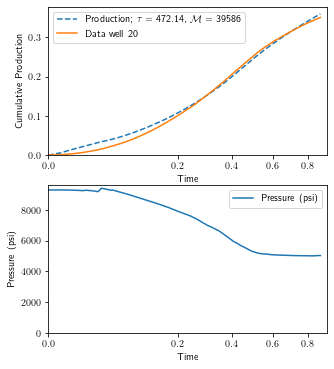

In [18]:
Filename="../../PressureData/SPE Well RTA Production Data/dataset_1_well_"+str(WellNumber)+".csv"
# This file contains pressure and production data. Rows 1 and 2 have information about units, so skip
D=pd.read_csv(open(Filename,"r"),skiprows=[1,2])
fig,(ax1,ax2)=plot_production_comparison(
    D,
    pvt_gas,
    result.params,
    filter_window_size=30,
    well_name="Data well "+str(WellNumber),
)
pp=PdfPages('WellsNP'+str(WellNumber)+'.pdf')
pp.savefig(fig)
pp.close()

In [16]:
pkl.dump(Results,file=open("Results.pkl","wb"))